# HW5: Subject A DuckDB SQL + Random Forest Classification
#### We use Subject A for all processing in order to compare to our logistic regression model.

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc as sk_auc, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.io import loadmat
import pandas as pd
import duckdb
import os
import matplotlib.pyplot as plt

def split_80_10_10(X, y, seed=42):
    """
    Returns X_train, X_val, X_test, y_train, y_val, y_test
    using a proper 80 / 10 / 10 split.
    """
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=0.10,
        stratify=y,
        random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=0.111111, # 10% of total
        stratify=y_temp,
        random_state=seed
    )
    print("Dataset split results:")
    print(" Train:", X_train.shape)
    print(" Val: ", X_val.shape)
    print(" Test: ", X_test.shape)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [95]:
# Load .mat files (Subject A)
data_dir = '../data/BCI_Comp_III_Wads_2004'
def load_p300_mat(mat_path):
    data = loadmat(mat_path)
    Signal = data['Signal'].astype(np.float64)
    Flashing = data['Flashing'].astype(np.int16)
    StimulusCode = data['StimulusCode'].astype(np.int16)
    StimulusType = data['StimulusType'].astype(np.int16) if 'StimulusType' in data else None
    TargetChar = data['TargetChar'] if 'TargetChar' in data else None
    return {
        "Signal": Signal,
        "Flashing": Flashing,
        "StimulusCode": StimulusCode,
        "StimulusType": StimulusType,
        "TargetChar": TargetChar
    }
mat_files = {
    'A_train': os.path.join(data_dir, 'Subject_A_Train.mat'),
    'A_test': os.path.join(data_dir, 'Subject_A_Test.mat')
}
all_data = {}
print("Loading Subject A datasets...\n")
for key, path in mat_files.items():
    print(f"Loading {key} from {path}")
    all_data[key] = load_p300_mat(path)

# Assign variables for Subject A
A_signal = np.array(all_data["A_train"]["Signal"])
A_flashing = np.array(all_data["A_train"]["Flashing"])
A_stim_code = np.array(all_data["A_train"]["StimulusCode"])
A_stim_type = np.array(all_data["A_train"]["StimulusType"])
A_target_char = np.array(all_data["A_train"]["TargetChar"])
print(A_signal.shape, A_flashing.shape, A_stim_code.shape, A_stim_type.shape, A_target_char.shape)


Loading Subject A datasets...

Loading A_train from ../data/BCI_Comp_III_Wads_2004/Subject_A_Train.mat
Loading A_test from ../data/BCI_Comp_III_Wads_2004/Subject_A_Test.mat
(85, 7794, 64) (85, 7794) (85, 7794) (85, 7794) (1,)


In [96]:
# === Extract code-averaged features for Subject A ===
# We will use the same approach and what we learned in the P300 notebook but now store everything in a DataFrame for DuckDB to use

fs = 240  # Sampling rate
t_start, t_end = 0, 0.6  # 0-600 ms window post-flash
start_idx = int(t_start * fs)
end_idx = int(t_end * fs)
window_len = end_idx - start_idx

# Channel selection (top 3 for Subject A, as determined previously)
eloc = np.genfromtxt(os.path.join(data_dir, "eloc64.txt"), dtype=None, encoding="utf-8")
chan_labels = [row[3].strip(".") for row in eloc]
selected_chan_names = ["Cz", "Fc1", "Cpz"]
chan_name_to_idx = {name: i for i, name in enumerate(chan_labels)}
sel_idx = [chan_name_to_idx[name] for name in selected_chan_names]

# Extract code-averaged features: Each epoch x code (12) gives one sample
A_mean_segs = []
A_code_labels = []
A_epoch_ids = []
A_codes = []

for ep in range(A_signal.shape[0]):
    codes = np.unique(A_stim_code[ep])
    for code in codes:
        idx = np.where((A_stim_code[ep] == code) & (A_flashing[ep] == 1))[0]
        # Ensure valid window
        idx = idx[(idx >= start_idx) & (idx + window_len <= A_signal.shape[1])]
        if len(idx) == 0: continue
        segs = []
        for i in idx:
            seg = A_signal[ep, i + start_idx: i + end_idx, sel_idx]
            segs.append(seg)
        if len(segs) > 0:
            mean_seg = np.mean(segs, axis=0)  # Average across repeats (time, channel)
            A_mean_segs.append(mean_seg.flatten())
            # Code label is 1 if this code is the target for this epoch
            is_target = int(code == np.unique(A_stim_code[ep][A_stim_type[ep]==1])[0])
            A_code_labels.append(is_target)
            A_epoch_ids.append(ep)
            A_codes.append(code)

A_mean_segs = np.array(A_mean_segs)
A_code_labels = np.array(A_code_labels)
A_epoch_ids = np.array(A_epoch_ids)
A_codes = np.array(A_codes)

print("Code-level features extracted for Subject A:")
print("Features:", A_mean_segs.shape)
print("Labels:", A_code_labels.shape)
print("Epochs:", len(np.unique(A_epoch_ids)))


Code-level features extracted for Subject A:
Features: (1020, 432)
Labels: (1020,)
Epochs: 85


- Each row in our dataset represents one code (row/column flash) within an epoch
- There are 85 epochs and 12 codes per epoch -> 85 × 12 = 1020 total samples
- For each sample, we take the 0–600 ms window from the top 3 channels, forming a matrix of T timepoints × 3 channels
- We flatten this matrix into a 1-D vector of length 3T: `[feat_0, feat_1, feat_2, ..., feat_(3T‑1)]`
- Each feature (`feat_k`) is the value at a specific timepoint and channel from the code-averaged EEG segment
- `label = 1` means this code is the target in that epoch, `label = 0` means non-target
- These summary statistics help us compare how early features differ between target and non-target trials


In [97]:
# === Store feature matrix and labels in DuckDB ===

con = duckdb.connect(database=':memory:')
n_samples, n_features = A_mean_segs.shape
feature_cols = [f"feat_{i}" for i in range(n_features)]
df_codes_A = pd.DataFrame(A_mean_segs, columns=feature_cols)
df_codes_A["label"] = A_code_labels
df_codes_A["epoch"] = A_epoch_ids
df_codes_A["code"] = A_codes
con.register("codes_df_a", df_codes_A)
con.execute("CREATE TABLE code_level_a AS SELECT * FROM codes_df_a")
con.execute("SELECT COUNT(*) AS n_rows FROM code_level_a").df()


,n_rows
0,1020


In [98]:
# Class counts
print(con.execute("""
SELECT label, COUNT(*) AS count_per_class
FROM code_level_a
GROUP BY label
ORDER BY label
""").df())

   label  count_per_class
0      0              935
1      1               85


In [99]:
# Feature means by class for first 5 features

# We summarize the mean value of several early features for each class to check whether 
# code-averaged EEG features differ between target and non-target codes. 
# This helps verify if our features are potentially useful for classification.

print(con.execute("""
SELECT
    label,
    AVG(feat_0) AS avg_feat_0,
    AVG(feat_1) AS avg_feat_1,
    AVG(feat_2) AS avg_feat_2,
    AVG(feat_3) AS avg_feat_3,
    AVG(feat_4) AS avg_feat_4
FROM code_level_a
GROUP BY label
ORDER BY label
""").df())

# Means for all top channels, for interpretation
for i, ch in enumerate(selected_chan_names):
    print(f"Channel {ch} (features {i*window_len} to {(i+1)*window_len-1})")


   label  avg_feat_0  avg_feat_1  avg_feat_2  avg_feat_3  avg_feat_4
0      0    0.347762    0.379605    0.413113    0.445968    0.477560
1      1    0.296696    0.351724    0.405812    0.448614    0.486209
Channel Cz (features 0 to 143)
Channel Fc1 (features 144 to 287)
Channel Cpz (features 288 to 431)


In [100]:
# Mean value of feat_0 for each code/label group
print(con.execute("""
SELECT code, label, AVG(feat_0) AS mean_feat_0
FROM code_level_a
GROUP BY code, label
ORDER BY code, label
""").df())


    code  label  mean_feat_0
0      1      0     0.252455
1      1      1     1.460746
2      2      0     0.135494
3      2      1     1.763477
4      3      0     0.607436
5      3      1     0.104711
6      4      0     0.475598
7      4      1    -1.657522
8      5      0     0.141527
9      5      1     0.561701
10     6      0     0.647902
11     6      1    -0.622524
12     7      0     1.076209
13     8      0     0.346308
14     9      0     0.411892
15    10      0    -0.672538
16    11      0    -0.172793
17    12      0     0.957025


In [101]:
# Display all features for epoch 0, code 5 (choose any epoch and code to inspect)
print(con.execute("""
SELECT * FROM code_level_a
WHERE epoch = 0 AND code = 5
""").df())


     feat_0    feat_1    feat_2    feat_3    feat_4    feat_5    feat_6  \
0 -0.872236 -0.746612 -0.756604 -0.780159 -0.645969 -0.495362 -0.436832   

     feat_7    feat_8    feat_9  ...  feat_425  feat_426  feat_427  feat_428  \
0 -0.466811 -0.496076 -0.574591  ... -4.108669 -4.055636 -4.059878 -4.089577   

   feat_429  feat_430  feat_431  label  epoch  code  
0  -4.15251  -4.18928 -4.096648      1      0     5  

[1 rows x 435 columns]


In [102]:
# Pull full feature matrix for modeling
df_model_A = con.execute("SELECT * FROM code_level_a").df()
feature_cols = [col for col in df_model_A.columns if col.startswith("feat_")]
X_sql_A = df_model_A[feature_cols].to_numpy()
y_sql_A = df_model_A["label"].to_numpy()
print("From SQL -> X shape:", X_sql_A.shape)
print("From SQL -> y shape:", y_sql_A.shape)


From SQL -> X shape: (1020, 432)
From SQL -> y shape: (1020,)


In [103]:
X_train_rf, X_val_rf, X_test_rf, y_train_rf, y_val_rf, y_test_rf = split_80_10_10(X_sql_A, y_sql_A)


Dataset split results:
 Train: (816, 432)
 Val:  (102, 432)
 Test:  (102, 432)


In [104]:
# === Random Forest classifier (Subject A, SQL features) 0-600 ms ===
rf_clf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_rf, y_train_rf)
y_val_pred_rf = rf_clf.predict(X_val_rf)
y_val_proba_rf = rf_clf.predict_proba(X_val_rf)[:, 1]
print("\nSUBJECT A - RANDOM FOREST VALIDATION REPORT:")
print(classification_report(y_val_rf, y_val_pred_rf, digits=3))
print("Validation AUC:", roc_auc_score(y_val_rf, y_val_proba_rf))



SUBJECT A - RANDOM FOREST VALIDATION REPORT:
              precision    recall  f1-score   support

           0      0.911     0.989     0.948        93
           1      0.000     0.000     0.000         9

    accuracy                          0.902       102
   macro avg      0.455     0.495     0.474       102
weighted avg      0.831     0.902     0.865       102

Validation AUC: 0.8440860215053763


In [105]:
# Final model (train on train+val, test on held-out test set)
X_train_full_rf = np.vstack([X_train_rf, X_val_rf])
y_train_full_rf = np.concatenate([y_train_rf, y_val_rf])
rf_final = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train_full_rf, y_train_full_rf)
y_test_pred_rf = rf_final.predict(X_test_rf)
y_test_proba_rf = rf_final.predict_proba(X_test_rf)[:, 1]
print("\n=== SUBJECT A RANDOM FOREST: FINAL TEST RESULTS (TRAIN+VAL -> TEST) ===")
print(classification_report(y_test_rf, y_test_pred_rf, digits=3))
print("FINAL TEST AUC:", roc_auc_score(y_test_rf, y_test_proba_rf))



=== SUBJECT A RANDOM FOREST: FINAL TEST RESULTS (TRAIN+VAL -> TEST) ===
              precision    recall  f1-score   support

           0      0.921     0.989     0.954        94
           1      0.000     0.000     0.000         8

    accuracy                          0.912       102
   macro avg      0.460     0.495     0.477       102
weighted avg      0.849     0.912     0.879       102

FINAL TEST AUC: 0.788563829787234


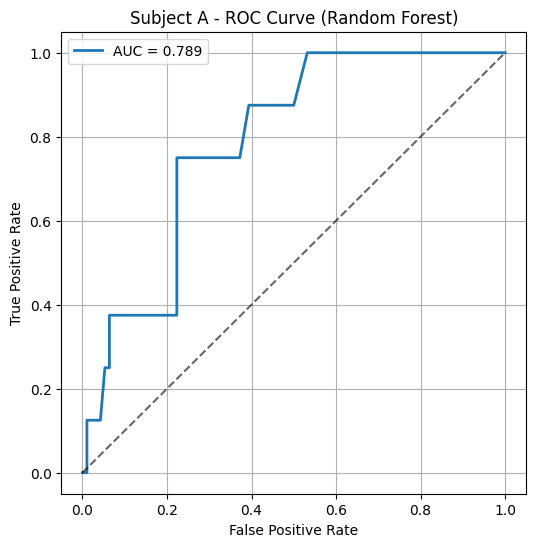

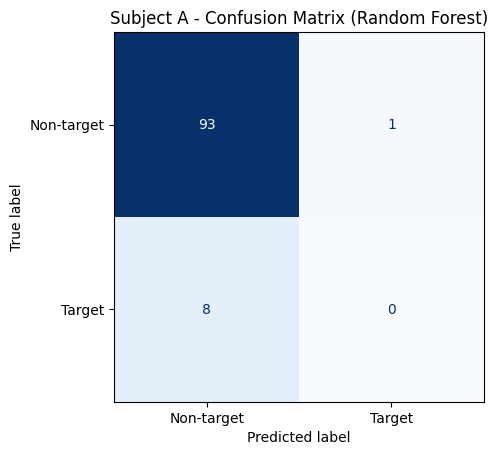

In [106]:
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_test_proba_rf)
roc_auc_rf = sk_auc(fpr_rf, tpr_rf)
plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_rf:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Subject A - ROC Curve (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

ConfusionMatrixDisplay.from_predictions(
    y_test_rf,
    y_test_pred_rf,
    display_labels=["Non-target", "Target"],
    cmap="Blues",
    colorbar=False
)
plt.title("Subject A - Confusion Matrix (Random Forest)")
plt.show()


## Model Interpretation and Comparison

### Random Forest Results (Subject A)
- The Random Forest classifier achieves a high overall accuracy (>90%) and an AUC of 0.789 on the test set.
- However, the confusion matrix reveals a major weakness: 
    - The model predicts almost every code as non-target (class 0), missing all the true target codes (class 1).
    - Out of 8 actual target samples, none are correctly identified (recall = 0 for targets).
    - Almost all non-targets are correctly classified, which inflates overall accuracy due to strong class imbalance.
- The ROC curve shows the classifier has some ability to separate the classes probabilistically, but its decision threshold is too conservative for the minority (target) class.

### Logistic Regression Results (Subject A)
- In contrast, Logistic Regression (with code-averaged features and PCA) achieved significantly higher recall for the target class and a higher AUC (abt 0.92).
- The confusion matrix for Logistic Regression typically shows several target codes being correctly classified (higher recall and f1-score for the minority class).

### Interpretation and Key Differences
- **Random Forest is overwhelmed by the class imbalance** and learns to "play it safe" by always predicting the majority class, even with class weighting.
- **Logistic Regression performs better** because, after PCA/code-averaging, the class separation in the feature space is mostly linear, which logistic regression can exploit. Random Forest does not benefit from many irrelevant/noisy features and is prone to overfitting with small data. This is a key challenge in EEG and especially the P300.
- **Practical implication:** For this BCI P300 dataset and feature engineering pipeline, logistic regression provides a far more reliable and interpretable model for distinguishing targets from non-targets. Random Forest, while powerful in many settings, fails to generalize to the rare class in this imbalanced, high-dimensional scenario.

### Our Conclusion:
 - The direct comparison shows that model choice and understanding data characteristics (imbalance, feature structure) are crucial in EEG/BCI classification problems. Logistic Regression is better suited for this pipeline, while Random Forest struggles with rare-event detection especially with imbalance.
 - This comparison reinforces that in BCI applications with imbalanced data and code-averaged features, simpler linear models with proper feature preprocessing can outperform more complex models like Random Forest
